<hr style="border-width:2px;border-color:#75DFC1">
<center><h1>5. Modèle NER pour l'indentification des entités </h1></center>
<hr style="border-width:2px;border-color:#75DFC1">

## 1. Inspection des donnée<a class="anchor" id="section_1"></a>

### 1a. Import des librairies  <a class="anchor" id="section_1a"></a>

In [1]:

pip install transformers


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install sentence_transformers

Note: you may need to restart the kernel to use updated packages.


In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud
sns.set_theme()

### 1b. Import du dataframe  <a class="anchor" id="section_1b"></a>

In [4]:
df=pd.read_csv('C:/cds/dataset.csv',sep="\t")

In [5]:
df.head(5)

,Commentaire,star,date,client,reponse,source,company,ville,maj,date_commande,ecart
0,"Bonjour , Ca doit faire 5 ans environ que je s...",1,2021-06-20 00:00:00+00:00,AUDREY Du 62,NaN,TrustPilot,ShowRoom,NaN,NaN,NaN,NaN
1,Vente lacoste article manquant photo prise sur...,1,2021-06-20 00:00:00+00:00,Nanasky De Verteuil,NaN,TrustPilot,ShowRoom,NaN,NaN,NaN,NaN
2,"Vente Lacoste Honteuse , article erroné , arti...",1,2021-06-19 00:00:00+00:00,Vanessa L,NaN,TrustPilot,ShowRoom,NaN,NaN,NaN,NaN
3,J'ai commandé des mules de la marque Moosefiel...,2,2021-06-19 00:00:00+00:00,Valery PERRAULT,"Bonjour , Je suis sincèrement navré d'apprendr...",TrustPilot,ShowRoom,NaN,NaN,NaN,NaN
4,Commande téléphone etat A+ . Livraison d un vi...,1,2021-06-19 00:00:00+00:00,JULIE DRINGENBERG,"Bonjour Julie , Je suis sincèrement désolé de ...",TrustPilot,ShowRoom,NaN,NaN,NaN,NaN


### 1c. Exploration du dataframe  <a class="anchor" id="section_1c"></a>

In [6]:
# affichage les dimensions de mon_dataframe
print(df.shape)

(19863, 11)


In [7]:
# affichage des caractéristiques du dataframe
df.dtypes

Commentaire       object
star               int64
date              object
client            object
reponse           object
source            object
company           object
ville             object
maj               object
date_commande     object
ecart            float64
dtype: object

In [8]:
# informations sur les variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19863 entries, 0 to 19862
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Commentaire    19834 non-null  object 
 1   star           19863 non-null  int64  
 2   date           19488 non-null  object 
 3   client         10215 non-null  object 
 4   reponse        8477 non-null   object 
 5   source         19863 non-null  object 
 6   company        19863 non-null  object 
 7   ville          4860 non-null   object 
 8   maj            5 non-null      object 
 9   date_commande  6686 non-null   object 
 10  ecart          6686 non-null   float64
dtypes: float64(1), int64(1), object(9)
memory usage: 1.7+ MB


In [9]:
#le nombre de valeurs manquantes
df.isnull().sum(axis=0)

Commentaire         29
star                 0
date               375
client            9648
reponse          11386
source               0
company              0
ville            15003
maj              19858
date_commande    13177
ecart            13177
dtype: int64

In [10]:
# le nombre de modalitès de chaque variable
df.nunique()

Commentaire      17174
star                 5
date              1880
client            7569
reponse           2033
source               2
company              2
ville             2457
maj                  5
date_commande      385
ecart               73
dtype: int64

In [11]:
#les modalités de la variable star
df['star'].value_counts()

5    7980
1    5122
4    3705
3    1747
2    1309
Name: star, dtype: int64

In [12]:
#les modalités de la variable source
df['source'].value_counts()

TrustedShop    14503
TrustPilot      5360
Name: source, dtype: int64

> Nous avons 3 fois plus de données issues de TrustedShop

In [13]:
#les modalités de la variable company
df['company'].value_counts()

ShowRoom    16823
VeePee       3040
Name: company, dtype: int64

> Nous avons 5 fois plus de données sur ShowRoom

In [14]:
# statistiques de la base de données
df.describe()

,star,ecart
count,19863.000000,6686.000000
mean,3.408398,14.286419
std,1.650531,10.373320
min,1.000000,1.000000
25%,1.000000,9.000000
50%,4.000000,12.000000
75%,5.000000,17.000000
max,5.000000,304.000000


## 2. Nettoyage des données  <a class="anchor" id="section_2"></a>

[prec](#section_1) - [suiv](#section_3)

In [15]:
# la variable maj contient plus de 99% de NaN. Je ne la conserve pas pour la suite de l'analyse
df=df.drop("maj",axis = 1)
# La variable ville contient 75% de Nan egalement. Je ne la conserve par non plus
df=df.drop("ville",axis = 1)
# il est normal de ne pas avoir tjs de valeurs dans la variable réponse

In [16]:
# Remplacement des Nan sur les dates par la valeur la plus frequente
df['date']=df['date'].fillna(df['date'].mode()[0])
df.isnull().sum(axis=0)

Commentaire         29
star                 0
date                 0
client            9648
reponse          11386
source               0
company              0
date_commande    13177
ecart            13177
dtype: int64

In [17]:
# recherche de doublons
print('il ya',df.duplicated().sum(),'doublons dans le fichier')

il ya 429 doublons dans le fichier


In [18]:
# supression des doublons
df=df.drop_duplicates()
print('il ya',df.duplicated().sum(),'doublons dans le fichier')

il ya 0 doublons dans le fichier


In [19]:
# nettoyage des commentaires
import re
def clean_text(text):
    text = re.sub(r"'", '', text)
    text = re.sub(r'[^\w\s]+', '', text)  # ponctuation
    text = re.sub(r'\s+', ' ', text) # double espace
    text = re.sub(r'\W+', ' ', text.lower())# caractères spéciaux  # minuscule 
    text = re.sub(" \d+", " ", text)# les chiffres
    return text
df['Commentaire']=df['Commentaire'].astype(str)
df['Commentaire'] = df['Commentaire'].apply(clean_text)

In [20]:
# supprimer les mots vides:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('french'))
stop_words.update(["a","à","â","abord","afin","ah","ai","aie","ainsi","allaient","allo","allô","allons","après","assez","attendu","au","aucun","aucune","aujourd","aujourd'hui","auquel","aura","auront","aussi","autre","autres","aux","auxquelles","auxquels","avaient","avais","avait","avant","avec","avoir","ayant","b","bah","beaucoup","bien","bigre","boum","bravo","brrr","c","ça","car","ce","ceci","cela","celle","celle-ci","celle-là","celles","celles-ci","celles-là","celui","celui-ci","celui-là","cent","cependant","certain","certaine","certaines","certains","certes","ces","cet","cette","ceux","ceux-ci","ceux-là","chacun","chaque","cher","chère","chères","chers","chez","chiche","chut","ci","cinq","cinquantaine","cinquante","cinquantième","cinquième","clac","clic","combien","comme","comment","compris","concernant","contre","couic","crac","d","da","dans","de","debout","dedans","dehors","delà","depuis","derrière","des","dès","désormais","desquelles","desquels","dessous","dessus","deux","deuxième","deuxièmement","devant","devers","devra","différent","différente","différentes","différents","dire","divers","diverse","diverses","dix","dix-huit","dixième","dix-neuf","dix-sept","doit","doivent","donc","dont","douze","douzième","dring","du","duquel","durant","e","effet","eh","elle","elle-même","elles","elles-mêmes","en","encore","entre","envers","environ","es","ès","est","et","etant","étaient","étais","était","étant","etc","été","etre","être","eu","euh","eux","eux-mêmes","excepté","f","façon","fais","faisaient","faisant","fait","feront","fi","flac","floc","font","g","gens","h","ha","hé","hein","hélas","hem","hep","hi","ho","holà","hop","hormis","hors","hou","houp","hue","hui","huit","huitième","hum","hurrah","i","il","ils","importe","j","je","jusqu","jusque","k","l","la","là","laquelle","las","le","lequel","les","lès","lesquelles","lesquels","leur","leurs","longtemps","lorsque","lui","lui-même","m","ma","maint","mais","malgré","me","même","mêmes","merci","mes","mien","mienne","miennes","miens","mille","mince","moi","moi-même","moins","mon","moyennant","n","na","ne","néanmoins","neuf","neuvième","ni","nombreuses","nombreux","non","nos","notre","nôtre","nôtres","nous","nous-mêmes","nul","o","o|","ô","oh","ohé","olé","ollé","on","ont","onze","onzième","ore","ou","où","ouf","ouias","oust","ouste","outre","p","paf","pan","par","parmi","partant","particulier","particulière","particulièrement","pas","passé","pendant","personne","peu","peut","peuvent","peux","pff","pfft","pfut","pif","plein","plouf","plus","plusieurs","plutôt","pouah","pour","pourquoi","premier","première","premièrement","près","proche","psitt","puisque","q","qu","quand","quant","quanta","quant-à-soi","quarante","quatorze","quatre","quatre-vingt","quatrième","quatrièmement","que","quel","quelconque","quelle","quelles","quelque","quelques","quelqu'un","quels","qui","quiconque","quinze","quoi","quoique","r","revoici","revoilà","rien","s","sa","sacrebleu","sans","sapristi","sauf","se","seize","selon","sept","septième","sera","seront","ses","si","sien","sienne","siennes","siens","sinon","six","sixième","soi","soi-même","soit","soixante","son","sont","sous","stop","suis","suivant","sur","surtout","t","ta","tac","tant","te","té","tel","telle","tellement","telles","tels","tenant","tes","tic","tien","tienne","tiennes","tiens","toc","toi","toi-même","ton","touchant","toujours","tous","tout","toute","toutes","treize","trente","très","trois","troisième","troisièmement","trop","tsoin","tsouin","tu","u","un","une","unes","uns","v","va","vais","vas","vé","vers","via","vif","vifs","vingt","vivat","vive","vives","vlan","voici","voilà","vont","vos","votre","vôtre","vôtres","vous","vous-mêmes","vu","w","x","y","z","zut","alors","aucuns","bon","devrait","dos","droite","début","essai","faites","fois","force","haut","ici","juste","maintenant","mine","mot","nommés","nouveaux","parce","parole","personnes","pièce","plupart","seulement","soyez","sujet","tandis","valeur","voie","voient","état","étions"])
stop_words.update(["donc", "alors","fait","toujour","c'est","j'ai","dit","n'est","qu'il","quand","chez","avoir","vraiment","car","cela","j a i","je","je ","Jai","jai","J","cest","2","3","faire"])
df['Commentaire'] = df['Commentaire'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

In [21]:
# supression des commentaires vides
df_clean= df[df['Commentaire'].notnull()]

In [22]:
df_clean.isnull().sum(axis=0)

Commentaire          0
star                 0
date                 0
client            9505
reponse          11021
source               0
company              0
date_commande    12751
ecart            12751
dtype: int64

In [23]:
df_clean=df[['Commentaire','star']]

In [24]:
df_clean= df_clean[df_clean['Commentaire'].notnull()]

In [25]:
df_clean.to_csv('C:/cds/df_clean.csv',sep="\t",index=False)

In [26]:
test = pd.read_csv('C:/cds/df_clean.csv',sep="\t")

In [27]:
test.head(5)

,Commentaire,star
0,bonjour ca ans membre showrooprive jamais souc...,1
1,vente lacoste article manquant photo prise art...,1
2,vente lacoste honteuse article erroné article ...,1
3,commandé mules marque moosefield déçue produit...,2
4,commande téléphone etat livraison vieux téléph...,1


In [28]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("Jean-Baptiste/camembert-ner")
#model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("Jean-Baptiste/camembert-ner")

nlp = pipeline("ner", model=model, tokenizer=tokenizer)



C:\Users\guyar\anaconda3\envs\on_environement\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [29]:

print(len(test["Commentaire"]))


19434


In [30]:

test['ner'] = ""

for i in range(1000):
    if len(str(test["Commentaire"][i]))>0:
        test['ner'] [i] = nlp(str(test["Commentaire"][i]))
test.head()


C:\Users\guyar\AppData\Local\Temp\ipykernel_3332\1815988263.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ner'] [i] = nlp(str(test["Commentaire"][i]))


,Commentaire,star,ner
0,bonjour ca ans membre showrooprive jamais souc...,1,"[{'entity': 'I-MISC', 'score': 0.92965335, 'in..."
1,vente lacoste article manquant photo prise art...,1,"[{'entity': 'I-ORG', 'score': 0.87975746, 'ind..."
2,vente lacoste honteuse article erroné article ...,1,"[{'entity': 'I-MISC', 'score': 0.5914179, 'ind..."
3,commandé mules marque moosefield déçue produit...,2,"[{'entity': 'I-MISC', 'score': 0.6058182, 'ind..."
4,commande téléphone etat livraison vieux téléph...,1,"[{'entity': 'I-ORG', 'score': 0.76842934, 'ind..."


In [31]:
print(test['Commentaire'][25] )

déçue souvent commandé showroom privé livrée rapidementje commande maillot bain reçois message informant retard livraison annoncée jour départ vacances numéro suivi mondial relay impossible savoir colis commande


In [32]:
print(test['ner'][25] )

[{'entity': 'I-ORG', 'score': 0.9825074, 'index': 24, 'word': '▁mondial', 'start': 164, 'end': 172}, {'entity': 'I-ORG', 'score': 0.983555, 'index': 25, 'word': '▁re', 'start': 172, 'end': 175}, {'entity': 'I-ORG', 'score': 0.9818635, 'index': 26, 'word': 'lay', 'start': 175, 'end': 178}]


In [33]:
test['ner_clear'] = ""
for i in range(500):
    nes = test['ner'] [i]
    cur = None
    agg = []
    for ne in nes: 
      entity=ne['entity']
      if entity != cur: 
        if cur is None: 
          cur = entity
        if agg: 
          #print(cur, tokenizer.convert_tokens_to_string(agg))
          agg = []
          cur = entity
      agg.append(ne['word'])
    test['ner_clear'][i] = str(cur) + " " + str(tokenizer.convert_tokens_to_string(agg))


C:\Users\guyar\AppData\Local\Temp\ipykernel_3332\2429664647.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ner_clear'][i] = str(cur) + " " + str(tokenizer.convert_tokens_to_string(agg))


In [34]:
test['ner_clear'][25]

'I-ORG mondial relay'

Text(0.5, 1.0, 'Répartition des notes par an')

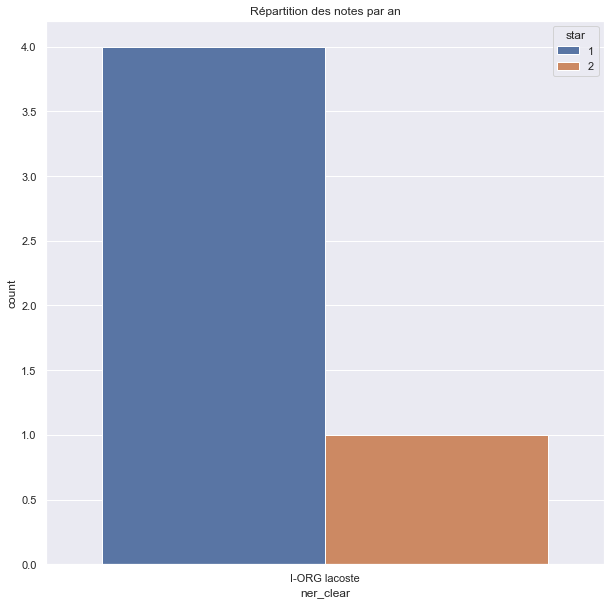

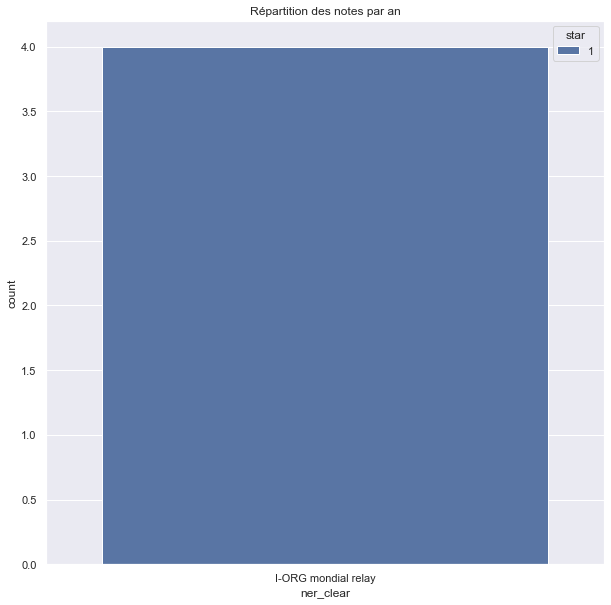

In [35]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud
sns.set_theme()

fig, ax = plt.subplots(figsize=(10,10))
sns.countplot(x="ner_clear",hue="star",data=test[test["ner_clear"]=='I-ORG lacoste'])
plt.title('Répartition des notes par an')

fig, ax = plt.subplots(figsize=(10,10))
sns.countplot(x="ner_clear",hue="star",data=test[test["ner_clear"]=='I-ORG mondial relay'])
plt.title('Répartition des notes par an')